## Содержание:
* [Стационарность](#stacionary)
* [Преобразование Бокса-Кокса](#boxcox)
* [Модели для предсказания значений временного ряда](#predict)
* [Метрики точности прогноза](#metrics)

Импортируем библиотеки

In [14]:
# Импортируем необходимые библиотеки

import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

Рутина с датасетами

In [15]:
# # аналогичным образом загружаем данные о пассажирах
# passengers = pd.read_csv('data/Annual domestic sales and advertising of Lydia E Pinkham Medicine Comp.csv')
# # также устанавливаем индекс и сортируем
df = pd.read_csv(os.path.join('data/Annual domestic sales and advertising of Lydia E Pinkham Medicine Comp.csv'),index_col=0)

df.head()


,sales,advertising
1,1016,608
2,921,451
3,934,529
4,976,543
5,930,525


In [16]:
df.describe()

,sales,advertising
count,54.000000,54.000000
mean,1829.481481,934.518519
std,632.738246,371.878898
min,921.000000,339.000000
25%,1344.250000,619.500000
50%,1778.500000,862.000000
75%,2201.250000,1090.000000
max,3438.000000,1941.000000


Отрисовываем временной ряд

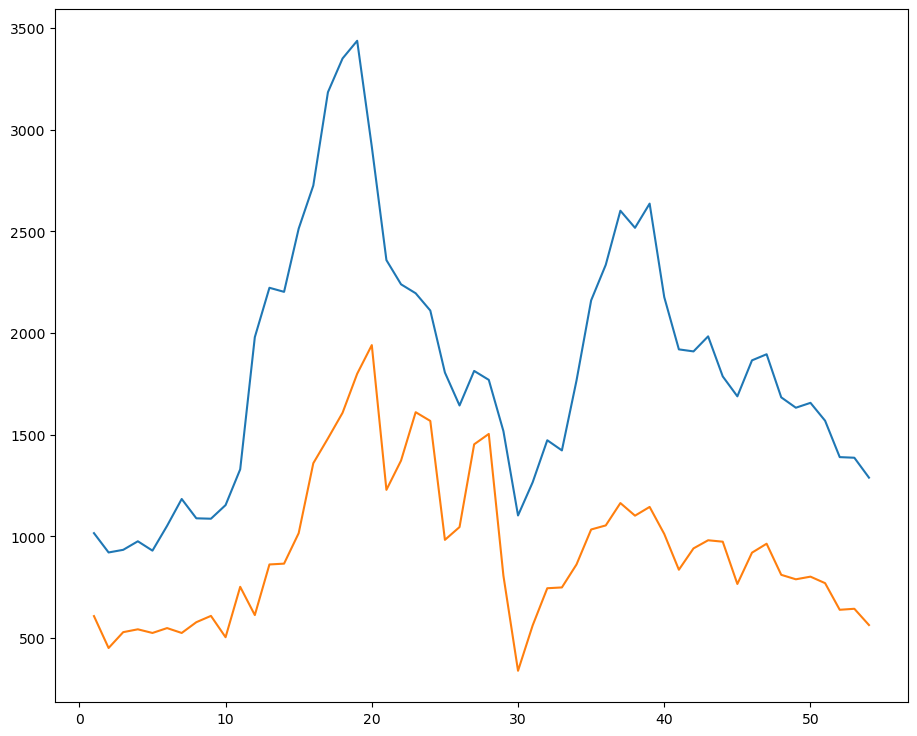

In [17]:
plt.plot(df) # Отрисовываем 2 графика по sales и advertising, поэтому пишем df

## Стационарный процесс  <a class="anchor" id="stacionary"></a>

Стационарный процесс - это случайный процесс, безусловное совместное распределение вероятностей которого не изменяется при сдвиге во времени. Следовательно, такие параметры, как среднее значение и дисперсия, также не меняются со временем, поэтому стационарные временные ряды легче прогнозировать.

Есть несколько способов установить, является ли временной ряд стационарным или нет, наиболее распространенными являются старая добрая визуализация, просмотр автокорреляции и выполнение статистических тестов.

Наиболее распространенным тестом является тест Дики-Фуллера (также называемый тест ADF), где нулевая гипотеза состоит в том, что временной ряд имеет единичный корень, другими словами, временной ряд не является стационарным.

Мы проверим, можно ли отвергнуть нулевую гипотезу, сравнив значение p с выбранным порогом (α), чтобы, если значение p меньше, мы могли отклонить нулевую гипотезу и предположить, что временной ряд с уверенностью является стационарным. уровень 1-α (технически мы просто не можем сказать, что это не так)

Временной ряд имеет единичный корень, или порядок интеграции один, если его первые разности образуют стационарный ряд. Это условие записывается как
$y_t\thicksim I(1)$ если ряд первых разностей $\triangle y_t=y_t-y_{t-1}$ является стационарным $\triangle y_t\thicksim I(0)$.

При помощи этого теста проверяют значение коэффициента $a$ в  авторегрессионном уравнении первого порядка AR(1)
$y_t=a\cdot y_{t-1}+\varepsilon_t,$
где $y_t$ — временной ряд, а $\varepsilon$— ошибка.

Если $a=1$, то процесс имеет единичный корень, в этом случае ряд $y_t$ не стационарен, является интегрированным временным рядом первого порядка $I(1)$. Если $|a|<1$, то ряд стационарный $I(0)$.


In [18]:
# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

In [19]:
def adfuller_get_p(ts):
    return adfuller(ts)[1]

def adfuller_print(ts,name = ""):
    alpha = 0.05

    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4],index=["Test Statistic","p-value","Lags","Number of Observations"])

    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value

    print(f"Проверка на стационарность для ряда {name}")
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha * 100}%. Ряд не стационарный.")

In [20]:
adfuller_print(df["sales"],"Продажи")

Проверка на стационарность для ряда Продажи
Test Statistic            -2.422391
p-value                    0.135516
Lags                       1.000000
Number of Observations    52.000000
Critical Value (1%)       -3.562879
Critical Value (5%)       -2.918973
Critical Value (10%)      -2.597393
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


In [21]:
adfuller_print(df["advertising"],"Реклама")

Проверка на стационарность для ряда Реклама
Test Statistic            -2.391303
p-value                    0.144206
Lags                       4.000000
Number of Observations    49.000000
Critical Value (1%)       -3.571472
Critical Value (5%)       -2.922629
Critical Value (10%)      -2.599336
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.


А теперь попробуем осуществить дифференцирование. Перед этим опять попробуем декомпозицию ряда.

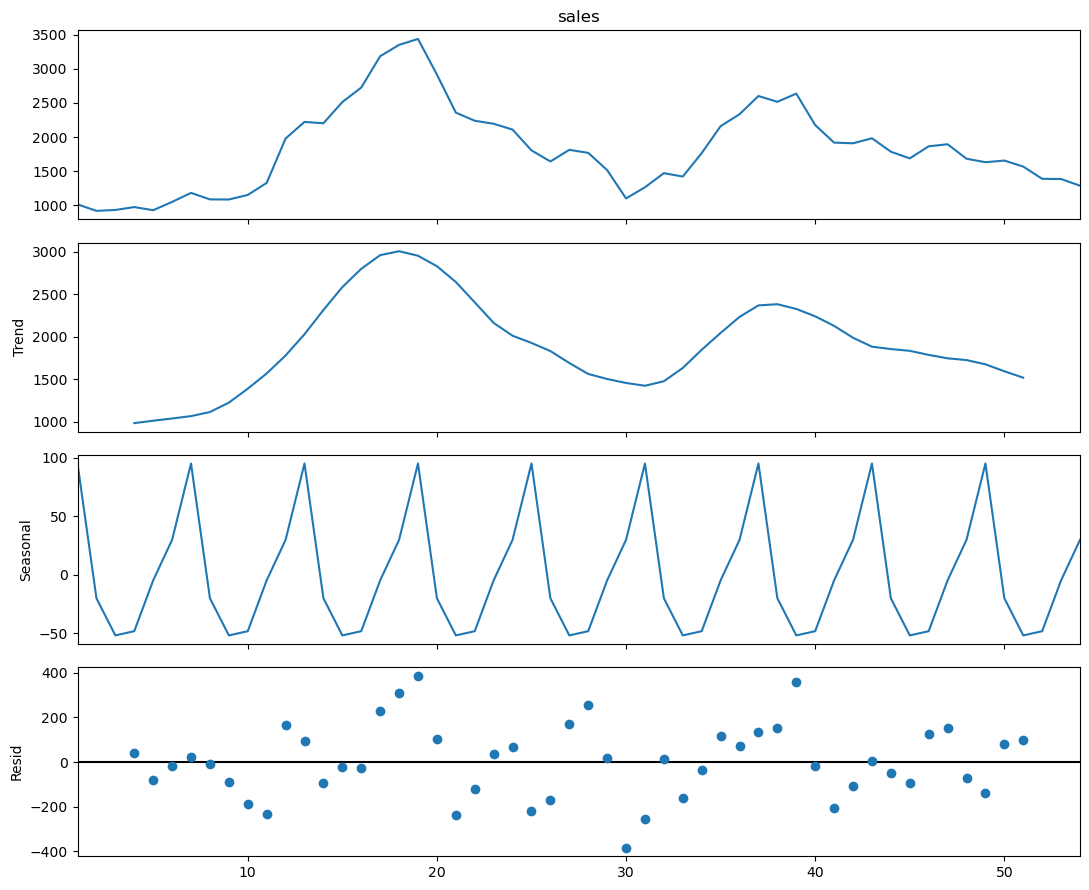

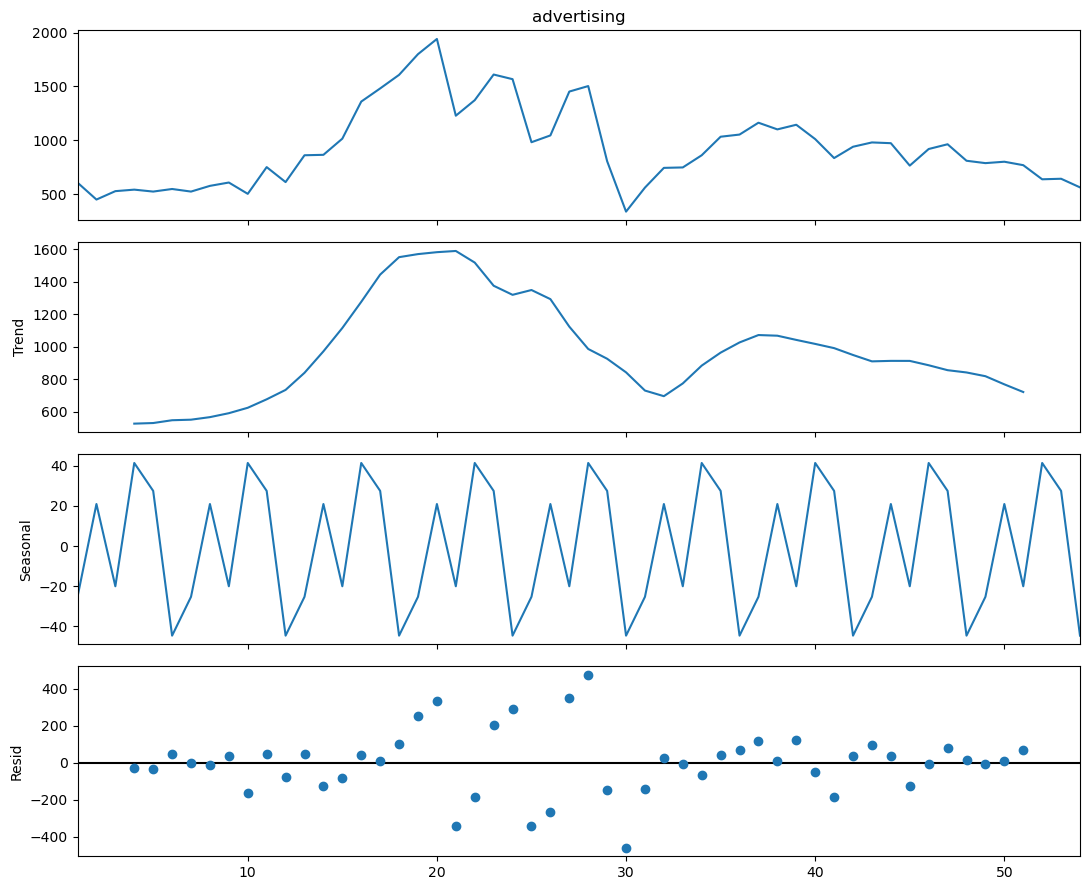

In [22]:
# импортируем функцию seasonal_decompose из statsmodels
# (то есть осуществляем декомпозицию сигнала/временного ряда)
from statsmodels.tsa.seasonal import seasonal_decompose

# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9


# применяем функцию к данным о перевозках
decompose = seasonal_decompose(df["sales"], 
                               period=6)
decompose.plot()

decompose_1 = seasonal_decompose(df["advertising"],
                                 period=6)
decompose_1.plot()

plt.show()

Создадим два временных ряда на основе имеющегося, только без тренда и сезонности.

Удаляем тренд согласно формуле: $y' = y_t - y_{t-1}$;

Удаляем сезонность согласно формуле: $y' = y_t - y_{t-s}$;

In [23]:
# nottrend = []
# s = 6
# notseason = []

# # выборка без тренда
# for i in range(1, len(df)):
#    nottrend.append(df["sales"][i] - df["sales"][i-1])

# # выборка без сезонности
# for i in range(s, len(df["sales"])):
#    notseason.append(df["sales"][i] - df["sales"][i-s])


In [24]:
def delete_trend(ts):
    nottrend = []
    for i in range(1,len(ts)):
        nottrend.append(ts[i] - ts[i-1])
    return nottrend

In [25]:
def delete_seson(ts,s):
    notseson = []
    for i in range(s,len(ts)):
        notseson.append(ts[i] - ts[i-s])
    return notseson

In [32]:
nottrend = []
s = 12
notseson = []

ts = df["sales"].to_numpy()

ts1 = df["advertising"].to_numpy()

nottrend = delete_trend(ts)

notseson = delete_seson(ts,s)

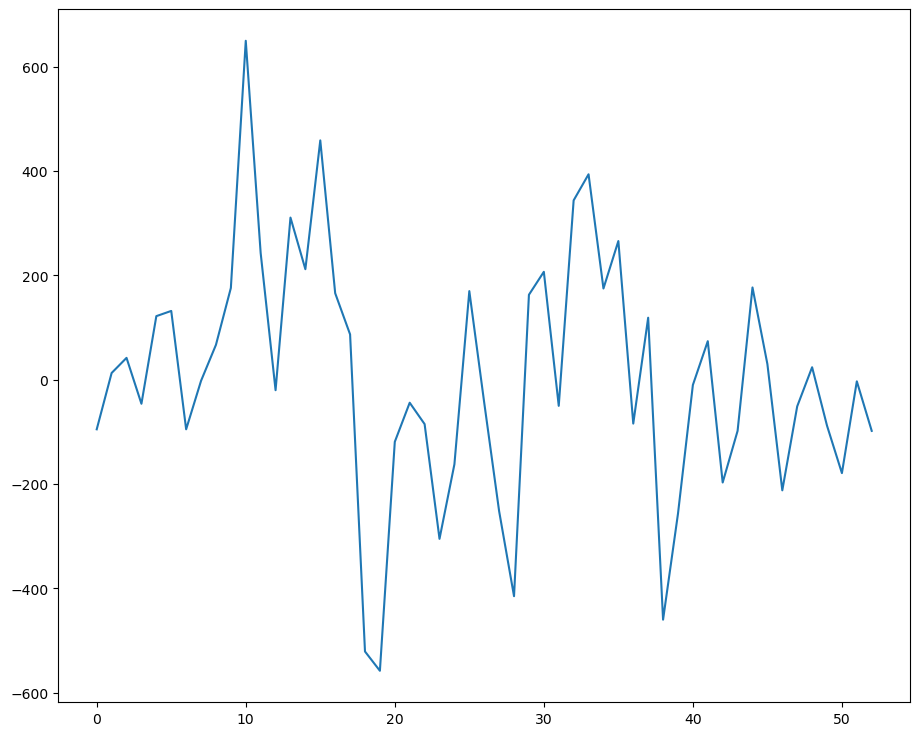

In [33]:
# отрисовываем временной ряд без тренда
plt.plot(nottrend)

Теперь проведем тест Дики-Фуллера на временном ряде без тренда

In [39]:
alpha = 0.05
name = "Пассажиры без тренда"
 
ts = nottrend


print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Пассажиры без тренда :
Test Statistic                 -4.471455
p-value                         0.000221
#Lags Used                      0.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


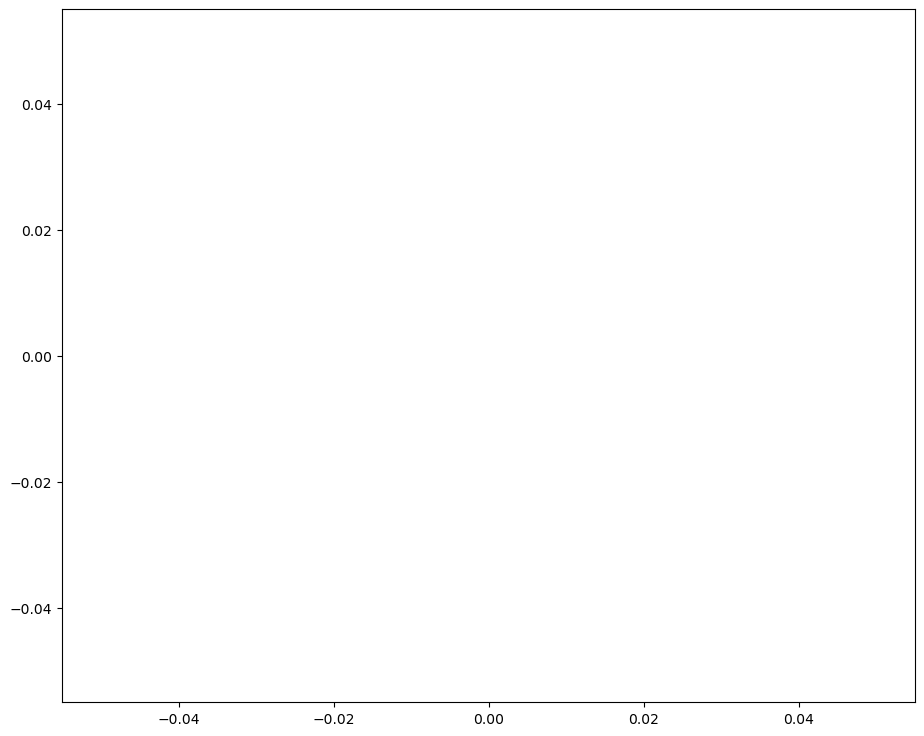

In [40]:
# отрисовываем временной ряд без сезонности
plt.plot(notseason)

Аналогичным образом проведем тест Дики-Фуллера на временном ряде без сезонности

In [41]:
alpha = 0.05
name = "Пассажиры без сезона"
 
ts = notseason

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Пассажиры без сезона :


ValueError: zero-size array to reduction operation maximum which has no identity

## Преобразование Бокса-Кокса <a class="anchor" id="boxcox"></a>

In [42]:
# Преобразование Бокса-Кокса
from scipy.stats import boxcox 

# вызываем функцию преобразования, которая выдает преобразованные данные и
# лучший параметр лямбда, который обеспечивает близость к нормальному
# распределению
transformed_data, best_lambda = boxcox(df["Passengers"]) 

# а теперь посмотрим на преобразованные данные
plt.plot(transformed_data) 

KeyError: 'Passengers'

Попробуем теперь из преобразованного временного ряда удалить тренд и
визуализировать его

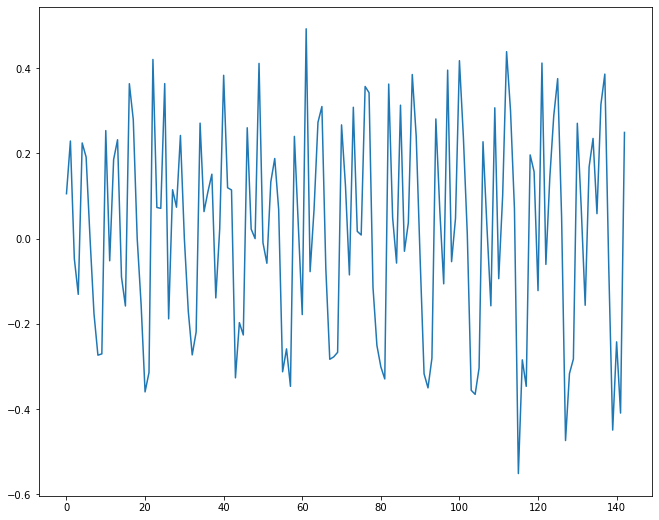

In [ ]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 

Удалив тренд из преобразованного Боксом-Коксом ряда, попробуем опять проверить его на стационарность. Что-то изменилось?

In [ ]:
alpha = 0.05
name = "Пассажиры после Кокса-Бокса"
 
ts = pnottrend

print(f'Тест Дики-Фуллера ряда {name} :')
dftest = adfuller(ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

if dfoutput["p-value"] < alpha:
    print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
else:
    print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

Тест Дики-Фуллера ряда Пассажиры после Кокса-Бокса :
Test Statistic                  -2.871708
p-value                          0.048738
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


## Модели для предсказания значений временного ряда <a class="anchor" id="predict"></a>

Первой моделью будет модель **AR**, или же autoregression - модель, которая использует связь между наблюдением и некоторым количеством предыдущих наблюдений.​

Сделаем случайный ряд и затем поработаем с ним.

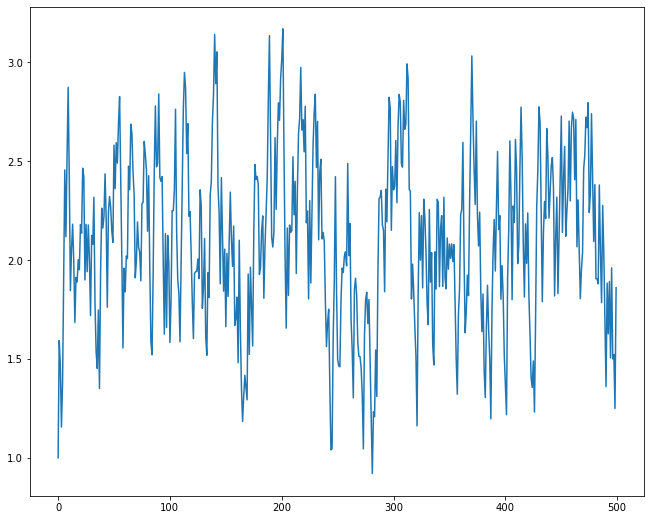

In [ ]:
# AR(1)

N = 500

ar1 = [1]

for i in range(1, N):
    ar1.append(0.76 * ar1[i-1] + np.random.random())

plt.plot(ar1)

Посмотрим какие у него стандартное отклонение и среднее.

In [ ]:
print(f"standart deviation = {np.std(ar1)}\n mean = {np.mean(ar1)}")

standart deviation = 0.4267708420608848
 mean = 2.0967054233743387


А теперь обернем его в датафрейм и посмотрим его обычную и частичную автокорреляцию. Что можно сказать по поводу этого временного ряда, глядя на эти параметры?

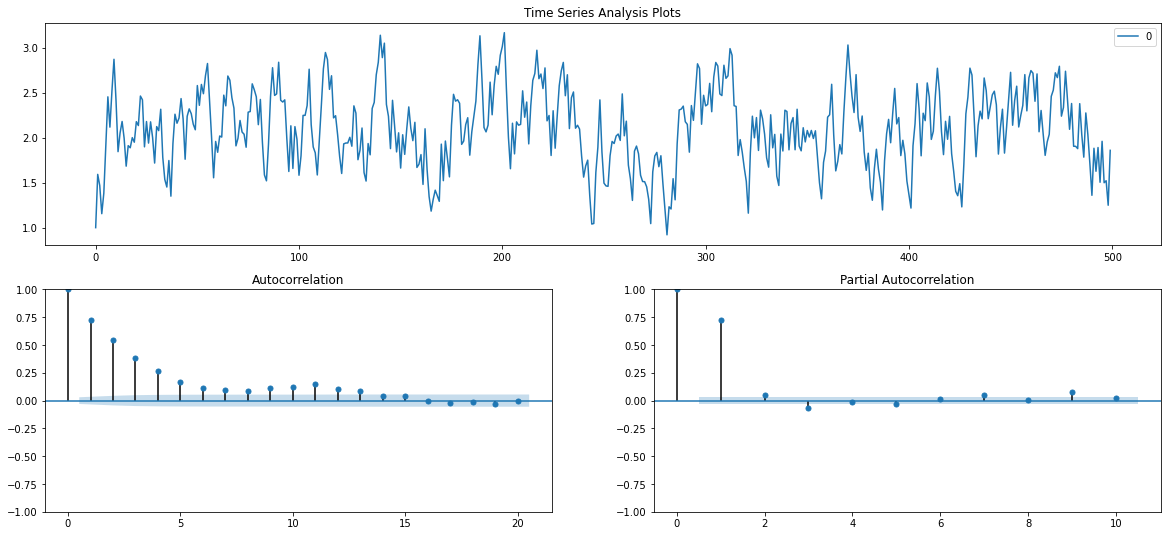

In [ ]:
ts = pd.DataFrame(ar1)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

Сделаем ещё один случайный ряд, но уже и с отрицательными значениями коэффициента

standart deviation = 0.45448254268148547
 mean = 0.2862734620928356


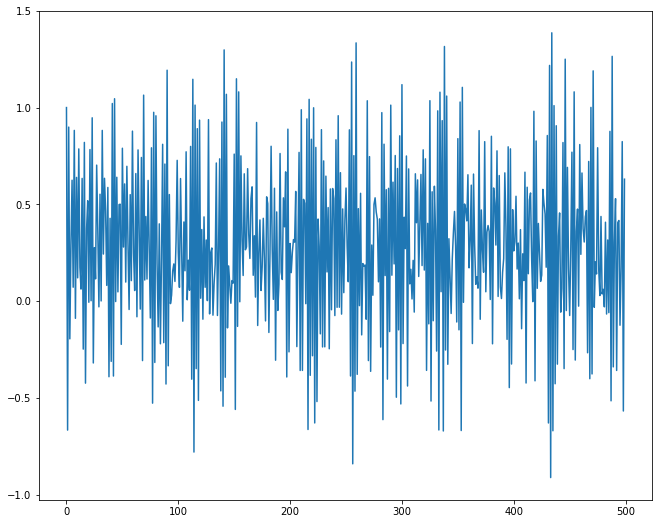

In [ ]:
# AR(1)

N = 500

ar2 = [1]

for i in range(1, N):
    ar2.append(- 0.76*ar2[i-1] + np.random.random())

plt.plot(ar2)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

А что можно сказать по поводу этого ряда?

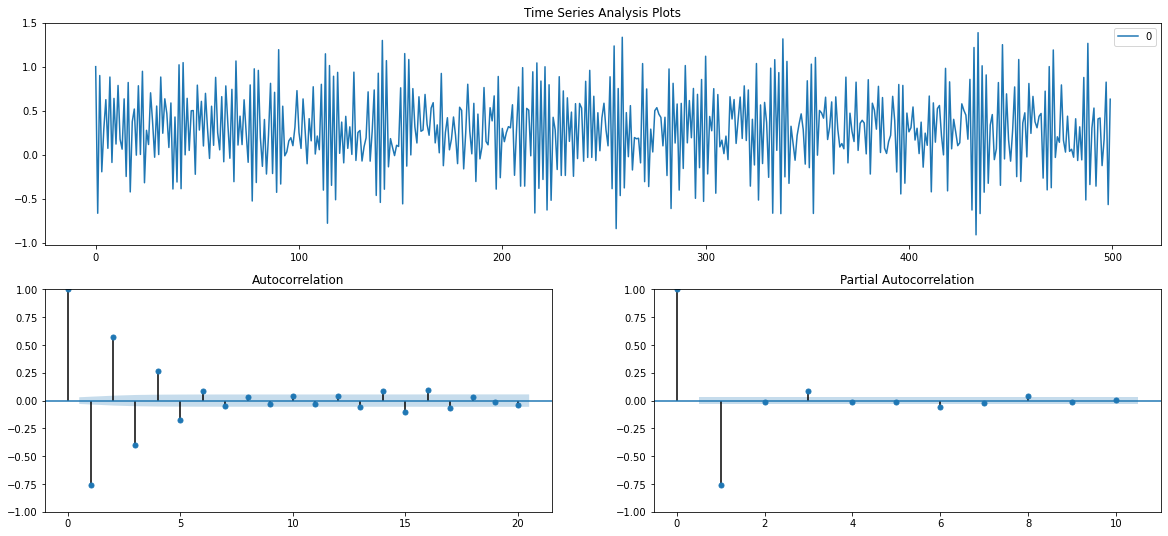

In [ ]:
ts = pd.DataFrame(ar2)

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

А теперь коэффициент >1 

standart deviation = 0.45448254268148547
 mean = 0.2862734620928356


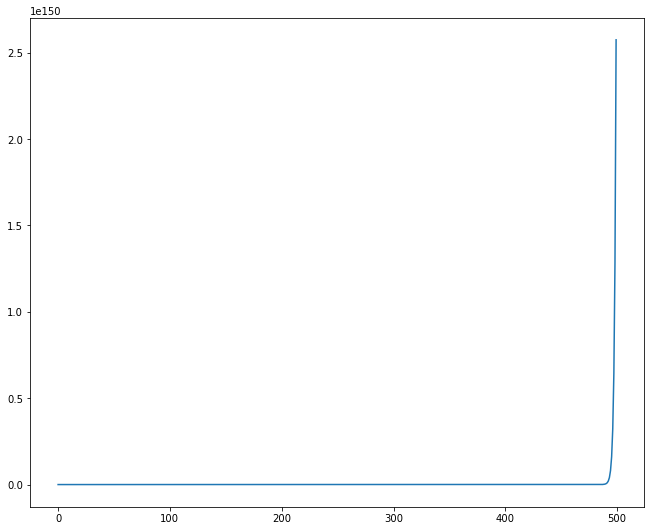

In [ ]:
# AR(1)

N = 500

ar3 = [1]

for i in range(1, N):
    ar3.append(2 * ar3[i-1] + np.random.random())

plt.plot(ar3)

print(f"standart deviation = {np.std(ar2)}\n mean = {np.mean(ar2)}")

Ладно, пора возвращаться к прогнозированию. Следаем прогноз с помощью AR модели, предварительно поделив выборки на обучающую, валидационную и тестовую.

In [ ]:
df = pd.read_csv('data/passengers.csv', names=["n","x"], skiprows=1)


df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

Визуализируем поделенные выборки.

* Обучающая выборка - синим цветом
* Валидационная выборка - оранжевым цветом
* Предсказываемая выборка - зеленым цветом

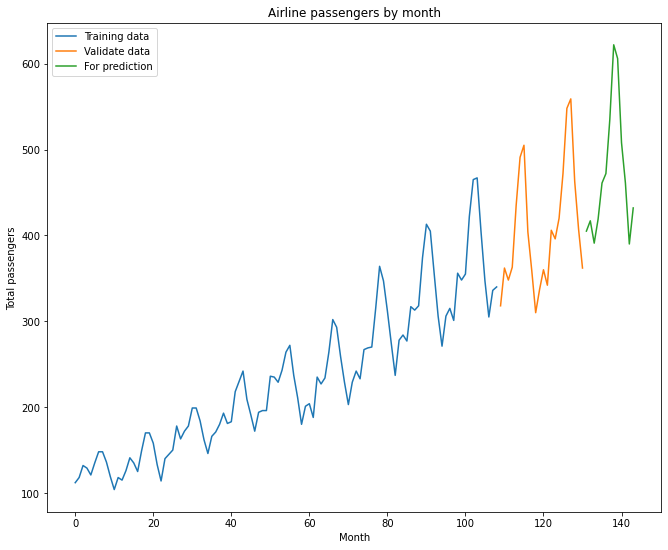

In [ ]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Airline passengers by month')
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(df.t, 3, old_names=False)
# обучаем
res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  144
Model:                     AutoReg(3)   Log Likelihood                4014.220
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 06 Oct 2023   AIC                          -8018.440
Time:                        04:06:33   BIC                          -8003.696
Sample:                             3   HQIC                         -8012.448
                                  144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   5.86e-15   1.14e+14      0.000       0.667       0.667
t.L1           1.0000    5.8e-15   1.72e+14      0.000       1.000       1.000
t.L2           0.3333   7.16e-17   4.65e+15      0.0

In [ ]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                  144
Model:                     AutoReg(3)   Log Likelihood                4014.220
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Fri, 06 Oct 2023   AIC                          -8018.440
Time:                        04:13:49   BIC                          -8003.696
Sample:                             3   HQIC                         -8012.448
                                  144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   3.86e-15   1.73e+14      0.000       0.667       0.667
t.L1           1.0000   3.79e-15   2.64e+14      0.000       1.000       1.000
t.L2           0.3333    8.5e-17   3.92e+15      0.0

Продолжаем экспериментировать

In [ ]:
sel = ar_select_order(df.x, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                  144
Model:                    AutoReg(13)   Log Likelihood                -497.994
Method:               Conditional MLE   S.D. of innovations             10.832
Date:                Fri, 06 Oct 2023   AIC                           1025.988
Time:                        04:14:08   BIC                           1069.116
Sample:                            13   HQIC                          1043.513
                                  144                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1490      2.857      1.802      0.072      -0.451      10.749
x.L1           0.7608      0.070     10.885      0.000       0.624       0.898
x.L2          -0.0853      0.069     -1.229      0.2

Смотрим, что он предсказал

No handles with labels found to put in legend.


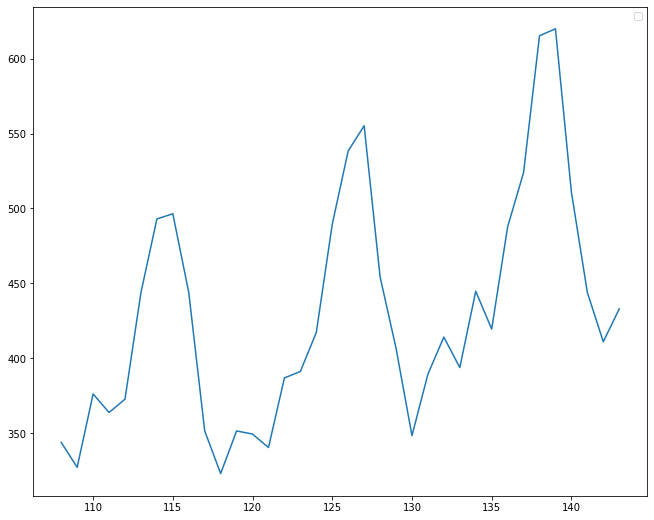

In [ ]:
fig = res.plot_predict(train_cutoff)

Формируем предсказанные временные ряды

In [ ]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

Отрисовываем их

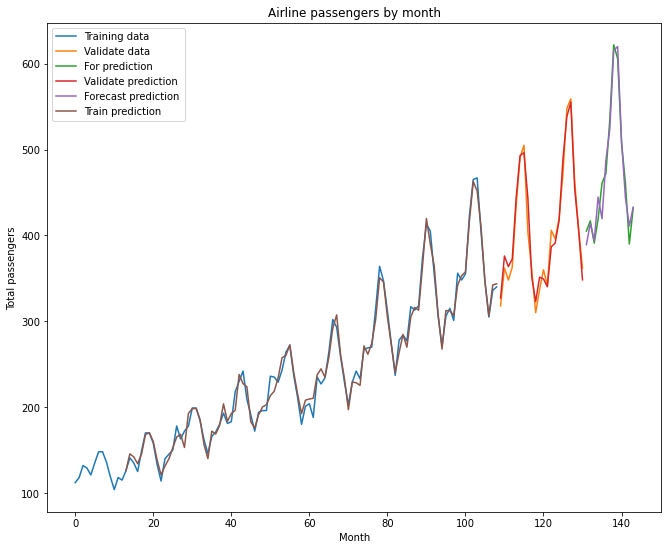

In [ ]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Airline passengers by month')
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

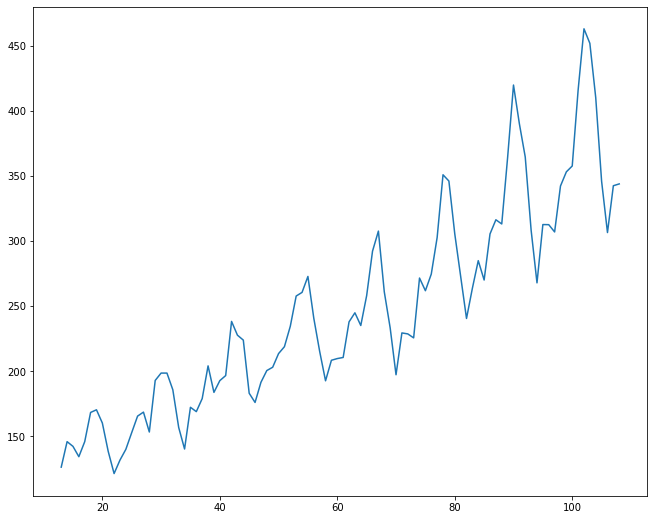

In [ ]:
plt.plot(pred)

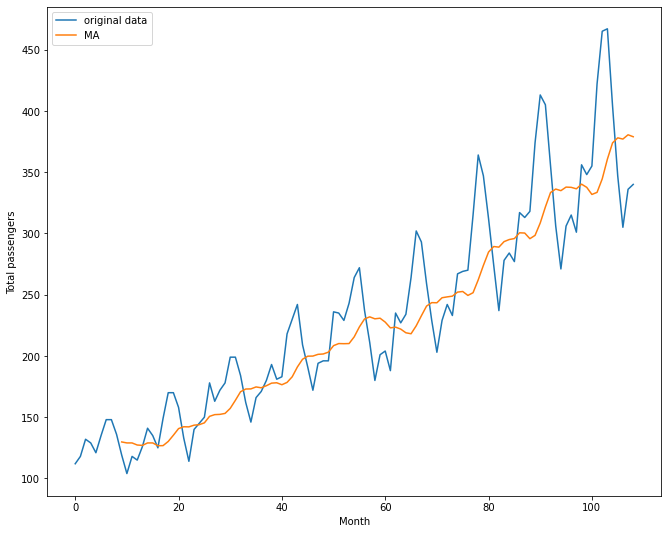

In [ ]:
# MA

df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

plt.plot(train_df["t"], train_df["x"], label="original data")
plt.plot(train_df["t"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

## Метрики точности прогноза <a class="anchor" id="metrics"></a>

* R2- коэффициент детерминации     ​
* MSE (RMSE) – mean squared error – среднеквадратичная ошибка​
* MAE – mean absolute error – средняя абсолютная ошибка​
* MAPE – mean absolute percentage error – средняя абсолютная ошибка в %​
* SMAPE – symmetric mean absolute percentage error – симметричная средняя абсолютная ошибка в %

Определяем метрики точности прогноза из библиотеки sklearn. Попробуй определить последнюю оставшуюся метрику **SMAPE** самостоятельно.

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

Вычислим значения ошибок модели AR, опираясь на предсказанные ею значения forecast.

In [ ]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))

RMSE: 17.540788248085953
MAPE: 0.030039826361232917
MAE: 13.680314913378826
R2:  0.943782157808505
